# DSCI 310: Airbnb Price Analysis

Oliver Gullery, Prithvi Sureka, Riddhi Battu, Rashi Selarka

In [119]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import folium

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xg
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
import requests
from branca.colormap import linear

## Aim

The aim of this data analysis project is to identify which of the
factors in the Airbnb Dataset are strong predictors of price. Doing so
will allow us obtain information which can determine if Airbnbs are
accurately priced.

In [120]:
# loading the data
url_listings = "http://data.insideairbnb.com/united-states/ny/new-york-city/2024-02-06/visualisations/listings.csv"

data = pd.read_csv(url_listings)
data.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,977395984065981849,Home in Brooklyn · 1 bedroom · 1 bed · 1 bath,95344065,Derek,Brooklyn,Sheepshead Bay,40.591790,-73.942850,Private room,30.0,31,1,2024-01-03,0.86,7,339,1,NaN
1,729947657876634696,Rental unit in The Bronx · 1 bedroom · 1 bed ·...,566660,Markus,Bronx,Longwood,40.827373,-73.903147,Private room,29.0,30,2,2023-12-31,0.14,2,34,1,NaN
2,648033676238017128,Rental unit in Bronx · ★4.89 · 1 bedroom · 1 b...,421601513,J Carlos Retals,Bronx,Kingsbridge,40.863940,-73.903120,Private room,30.0,30,18,2023-12-26,0.95,3,359,6,NaN


### Export the dataset to our data/raw folder

In [121]:
data.to_csv("../data/raw/airbnb_data_2024")

### Data Shape & Datatypes

In [122]:
print(f'Data Shape: {data.shape}\n')



print(f'Data datatypes: \n{data.dtypes}')

Data Shape: (39202, 18)

Data datatypes: 
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                             float64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
license                            object
dtype: object


### Summary Statistics

In [123]:
data.info()

data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39202 entries, 0 to 39201
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              39202 non-null  int64  
 1   name                            39202 non-null  object 
 2   host_id                         39202 non-null  int64  
 3   host_name                       39197 non-null  object 
 4   neighbourhood_group             39202 non-null  object 
 5   neighbourhood                   39202 non-null  object 
 6   latitude                        39202 non-null  float64
 7   longitude                       39202 non-null  float64
 8   room_type                       39202 non-null  object 
 9   price                           24267 non-null  float64
 10  minimum_nights                  39202 non-null  int64  
 11  number_of_reviews               39202 non-null  int64  
 12  last_review                     

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,3.920200e+04,3.920200e+04,39202.000000,39202.000000,24267.000000,39202.000000,39202.000000,27702.000000,39202.000000,39202.000000,39202.000000
mean,3.241181e+17,1.611708e+08,40.729073,-73.946289,206.502946,29.634432,25.172440,0.953946,46.842661,151.142008,5.636575
std,4.185256e+17,1.739680e+08,0.056339,0.054813,1004.705385,30.172981,58.097482,1.633604,146.693303,145.985782,16.510633
min,2.595000e+03,1.678000e+03,40.500314,-74.251907,10.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,2.021553e+07,1.671337e+07,40.688770,-73.982870,80.000000,30.000000,0.000000,0.100000,1.000000,0.000000,0.000000
50%,4.683017e+07,7.964657e+07,40.726230,-73.954241,129.000000,30.000000,4.000000,0.360000,1.000000,110.000000,0.000000
75%,7.746345e+17,2.881116e+08,40.762500,-73.926990,212.000000,30.000000,22.000000,1.300000,6.000000,304.000000,4.000000
max,1.084860e+18,5.597047e+08,40.911380,-73.713650,100000.000000,1250.000000,1887.000000,78.250000,827.000000,365.000000,1163.000000


### Identifying Null values & Duplicates

In [124]:
print(f'Null Values: {data.isna().sum()}\n')

print(f'Duplicated Values: {data.duplicated().sum()}')

Null Values: id                                    0
name                                  0
host_id                               0
host_name                             5
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                             14935
minimum_nights                        0
number_of_reviews                     0
last_review                       11500
reviews_per_month                 11500
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
license                           34397
dtype: int64

Duplicated Values: 0


### Correlation Matrix (Ranked with Top Ten Correlations)

In [125]:
# creating correlation matrix
corr_matrix = data.select_dtypes('int64')

def rank_correlations(corr_matrix):
    # flattening matrix
    flattened_matrix = corr_matrix.stack().reset_index()

    #renaming columns
    flattened_matrix.columns = ['Variable_1', 'Variable_2', 'Correlation']

    # removing duplicate variable names
    flattened_matrix = flattened_matrix.loc[flattened_matrix['Variable_1'] != flattened_matrix['Variable_2']]

    corr_column = flattened_matrix['Correlation']

    flattened_matrix = flattened_matrix.iloc[abs(corr_column).argsort()[::-1]]

    flattened_matrix = flattened_matrix.loc[flattened_matrix['Correlation'].duplicated()]


    print(f'Top 10 Variable Correlations: \n{flattened_matrix.head(10)}')

rank_correlations(corr_matrix)

Top 10 Variable Correlations: 
        Variable_1 Variable_2  Correlation
219577       31368    host_id    558734210
40447         5778    host_id    558734210
213725       30532    host_id    558446111
35365         5052    host_id    558446111
32810         4687    host_id    558446111
7218          1031    host_id    558446111
179859       25694    host_id    558446111
213221       30460    host_id    558446111
89811        12830    host_id    558240264
106975       15282    host_id    558240264


## Takwaways From Preliminary EDA

-   Our shape function tells us we have 48895 rows and 16 features which
    includes our target variable `price`.

-Looking at the columns from our info() function we can identify that
name is text data which could provide some valuable insights. We can
also infer that any id information (`id` and `host_id`) and variables
such as `host_name` will not provide any key information, thus, we can
drop them for our data analysis.

-   The describe() function provided key summary statistics for our
    numerical columns which included the following metrics: count, mean,
    standard deviation, minimum, and maximum. This helps us obtain an
    idea as to the spread of our data. Our info() function gave us
    further information about the datatypes, columns, and amount of data
    we have. Through this analysis in addition to our dtypes() function
    we can identify that last_review is an object dtype but could be
    converted into a pandas datatime format to further utilize pandas
    datatime capabilities. Examples of such would be splitting the data
    into year, month and day to identify if there are any temporal
    patterns across months or years.

-   Our isna() function informed us of the null values which are
    included in the dataset. The column `host_name` has 5 null values, we can address this by
    imputing a blank string to indicate the information is not provided.
    Our `reviews_per_month` column and `last_review` column have 11500.
    As these have identical amounts of null values, we can assume that
    if an Airbnb listing doesn’t have a review, instead of zero the dataset
    has a null values. This can be addressed through imputing zero into
    the null vaues in the reviews_per_month column. We also saw for `license` that in the situations where they are unlicensed, the dataset has null values, so we will also be replacing the NaNs with 'Unlicensed'.

### Summary

In order to prepare our data for further analysis we must perform some
preliminary feature engineering which will involve:
* Convert `id` and `host_id` into object datatypes to prepare them to be dropped.
* Converting the data type of the `last_review` column, then split the `last_review` into year, month and day.
* Imputing zeros into the `reviews_per_month` and 'Unlicensed' into `license` null values
* Imputing an empty string into the null values for `host_name`

After these changes are made we can proceed to split our data into a
train and test set and label our data by data type (numeric,
categorical, text, and drop columns).


## Preliminary Feature Engineering
In order to prepare our data for further analysis, we must perform some preliminary feature engineering which will involve:

1.  **Convert `id` and `host_id` into object datatypes to prepare them
    to be dropped.**

In [126]:
data['id'] = str(data['id'])
data['host_id'] = str(data['host_id'])

2.  **Convert the data type of the `last_review` column to datetime.**

In [127]:
data['last_review'] = pd.to_datetime(data['last_review'])

3.  **Split the `last_review` column into year, month, and day
    columns, and then drop it.**

In [128]:
data['last_review_year'] = data['last_review'].dt.year
data['last_review_month'] = data['last_review'].dt.month
data['last_review_day'] = data['last_review'].dt.day
data = data.drop('last_review', axis=1)

4.  **Impute zeros into the `reviews_per_month`, and "Unlicensed" into `license` column for null
    values.**

In [129]:
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)
data['license'] = data['license'].fillna('Unlicensed')

5.  **Impute an empty string into the `host_name` columns for
    null values.**

In [130]:
data['host_name'] = data['host_name'].fillna('')

After these changes are made we can proceed to split our data and
perform further analysis.

### Putting It All Together

Now, let’s put all these steps together to perform the preliminary
feature engineering tasks.

In [131]:
""" # Convert last_review to datetime
data['last_review'] = pd.to_datetime(data['last_review'])

# Extract year, month, and day from last_review
data['year'] = data['last_review'].dt.year
data['month'] = data['last_review'].dt.month
data['day'] = data['last_review'].dt.day

# Impute zeros for reviews_per_month null values
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

# Impute empty string for host_name null values
data['host_name'] = data['host_name'].fillna('')

data.head(3) """

" # Convert last_review to datetime\ndata['last_review'] = pd.to_datetime(data['last_review'])\n\n# Extract year, month, and day from last_review\ndata['year'] = data['last_review'].dt.year\ndata['month'] = data['last_review'].dt.month\ndata['day'] = data['last_review'].dt.day\n\n# Impute zeros for reviews_per_month null values\ndata['reviews_per_month'] = data['reviews_per_month'].fillna(0)\n\n# Impute empty string for host_name null values\ndata['host_name'] = data['host_name'].fillna('')\n\ndata.head(3) "

### Splitting Data (Training / Testing)

In [132]:
train_df, test_df = train_test_split(data, test_size=0.2)

# numeric data
numerical_data = data.select_dtypes(include=["int64", "float64"])
numerical_data = numerical_data.columns
numerical_data = [col for col in numerical_data]
numerical_data.remove('price')

# text data
text_data = ["name"]

# drop data
drop_data = ["host_name", "host_id", "id"]

# Categorical Data
categorical_data = data.select_dtypes(include=["object"])
categorical_data = categorical_data.columns
columns_to_exclude = text_data + drop_data
categorical_data = [col for col in categorical_data if col not in columns_to_exclude]

# Target Data
target = 'price'

print(f'Train Shape: {train_df.shape}\nTest Shape: {test_df.shape}\n')
print(f"Numerical Columns: {numerical_data}/n")
print(f"Categorical Columns: {categorical_data}\n")
print(f"Text Data: {text_data}\n")
print(f"Drop Columns: {drop_data}\n")
print(f"Target Column: {target}\n")

Train Shape: (31361, 20)
Test Shape: (7841, 20)

Numerical Columns: ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'last_review_year', 'last_review_month', 'last_review_day']/n
Categorical Columns: ['neighbourhood_group', 'neighbourhood', 'room_type', 'license']

Text Data: ['name']

Drop Columns: ['host_name', 'host_id', 'id']

Target Column: price



# Exploratory Data Analysis (Visualizations)

### Figure 1. Map with Distribution of Listings by Location and Price

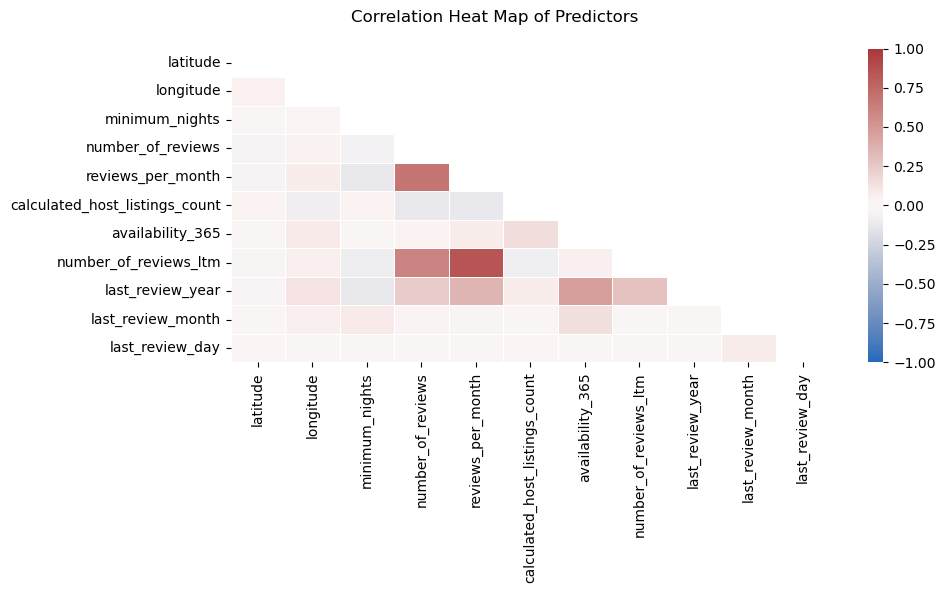

In [133]:
train_corr = train_df[numerical_data].corr(method = 'pearson')
mask = np.zeros_like(train_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True ## Uncomment to clear half the map

fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(train_corr, mask=mask, vmin=-1, vmax=1, center=0, linewidths=.5, cmap="vlag")
fig.suptitle('Correlation Heat Map of Predictors', fontsize=12)
fig.tight_layout()

Looking at this map, there appears to be strong multicollinearity between reviews per month and number of reviews, reviews per month and number_of_reviews_ltm (last month? long term?), and between number of reviews and number_of_reviews_ltm (last month? long term?). Thus, we'll probably need to consider interactions between these predictors if we use them in our model.

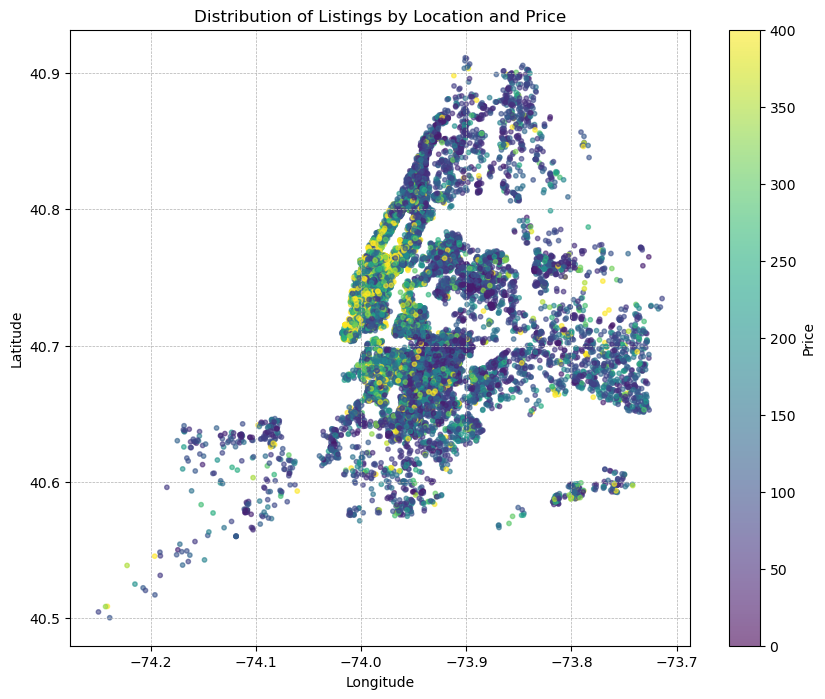

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [134]:
plt.figure(figsize=(10, 8))

# Setting color limits to more typical range, e.g., 0 to 400
# Adjust these values based on your specific dataset and its distribution
vmin, vmax = 0, 400

sc = plt.scatter(train_df['longitude'], train_df['latitude'], c=train_df['price'], cmap='viridis', s=10, alpha=0.6, vmin=vmin, vmax=vmax)
plt.colorbar(sc, label='Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribution of Listings by Location and Price')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
plt.figure(figsize=(10, 8))

### Figure 2. Price vs Number of Reviews Coloured by Room Type Scatterplot

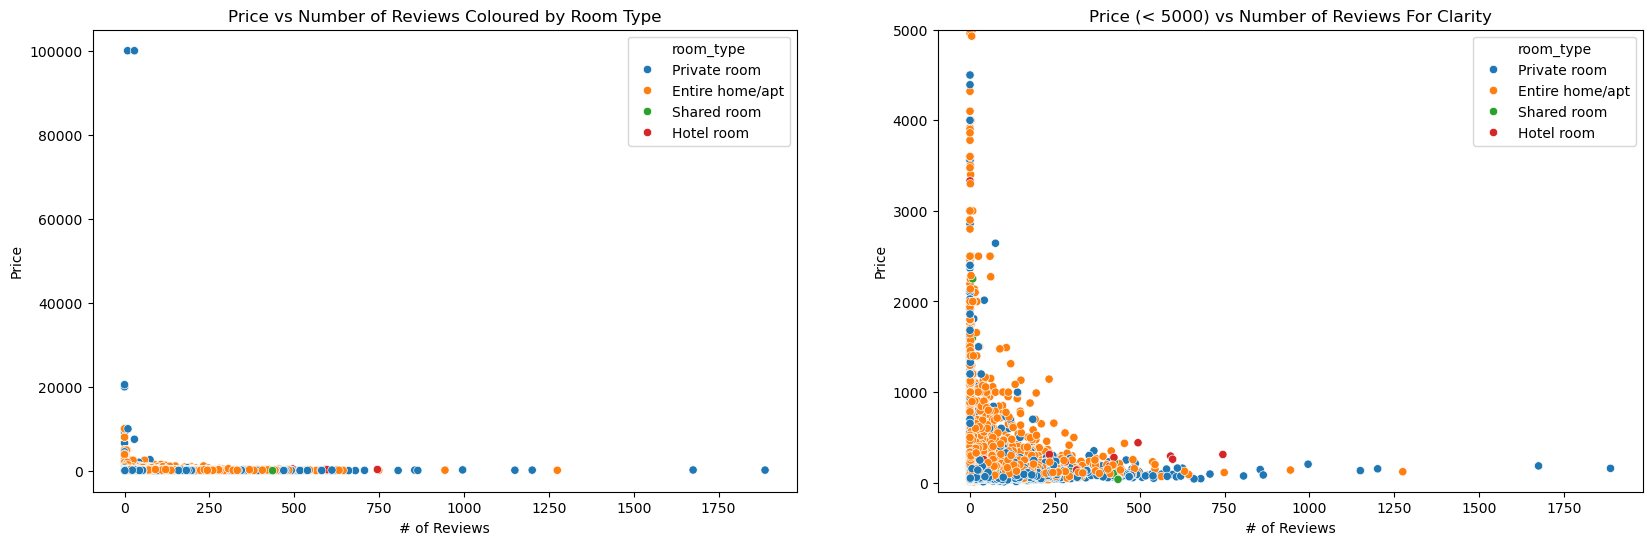

In [135]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 6))

sns.scatterplot(train_df, x = 'number_of_reviews', y='price', hue='room_type', ax=ax[0])
ax[0].set_title("Price vs Number of Reviews Coloured by Room Type")
ax[0].set(xlabel="# of Reviews", ylabel="Price")

sns.scatterplot(train_df, x = 'number_of_reviews', y='price', hue='room_type', ax=ax[1])
ax[1].set_title("Price (< 5000) vs Number of Reviews For Clarity")
ax[1].set(xlabel="# of Reviews", ylabel="Price")
ax[1].set_ylim(-100, 5000)

fig.tight_layout
plt.show()

### Figure 3. Price vs Reviews Per Month Coloured by Room Type Scatterplot

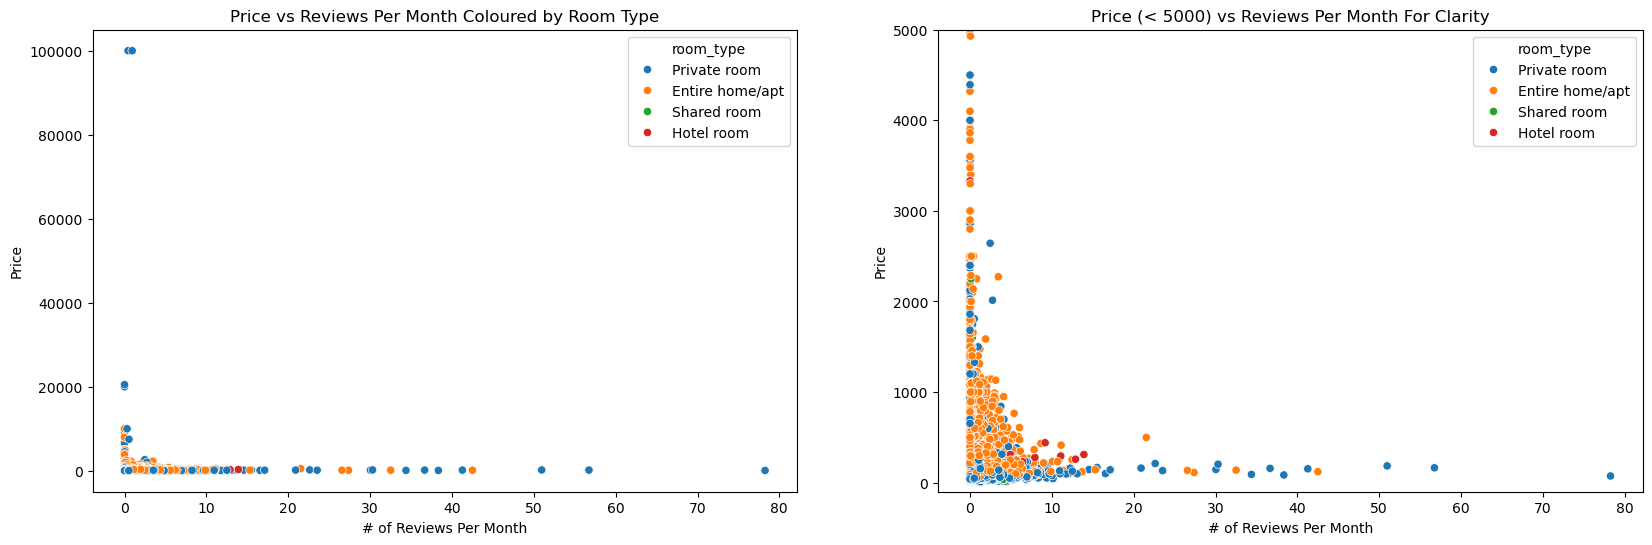

In [136]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 6))

sns.scatterplot(train_df, x = 'reviews_per_month', y='price', hue='room_type', ax=ax[0])
ax[0].set_title("Price vs Reviews Per Month Coloured by Room Type")
ax[0].set(xlabel="# of Reviews Per Month", ylabel="Price")

sns.scatterplot(train_df, x = 'reviews_per_month', y='price', hue='room_type', ax=ax[1])
ax[1].set_title("Price (< 5000) vs Reviews Per Month For Clarity")
ax[1].set(xlabel="# of Reviews Per Month", ylabel="Price")
ax[1].set_ylim(-100, 5000)

fig.tight_layout
plt.show()

### Figure 4. Neighbourhood Group vs Log Price Coloured Boxplot

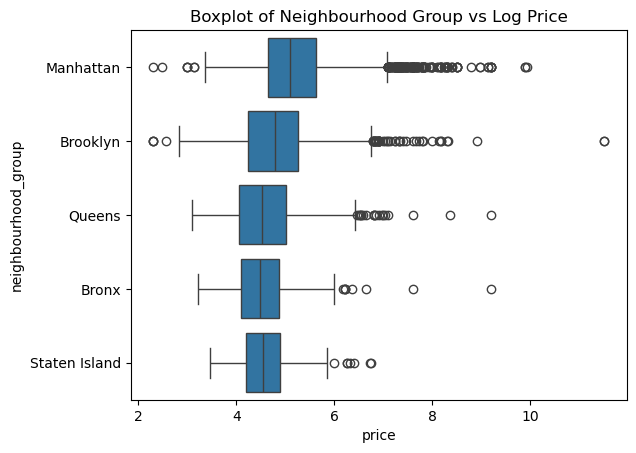

In [137]:
log_price = np.log(train_df['price'])
sns.boxplot(data=train_df, x=log_price, y='neighbourhood_group')
plt.title("Boxplot of Neighbourhood Group vs Log Price")
plt.show()

### Figure 5. Room Type Vs Log Price Box plot

-   This visualiation was created to see if there is any relationship
    between room type and log price.
-   As we can see price differs among the different room types
    indicating that room type may be able to account for the variation
    in price.

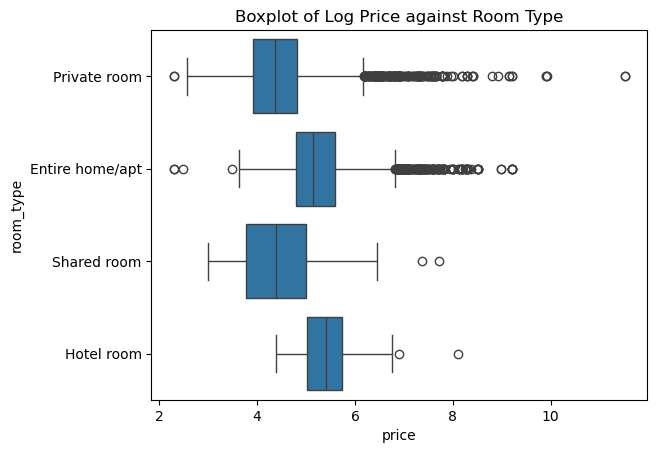

In [138]:
sns.boxplot(data=train_df, x=log_price, y='room_type')
plt.title("Boxplot of Log Price against Room Type")
plt.show()

# Preprocessing & Transformations

# Preparing Data

Splitting data into X and y train and test sets and performing imputation on
missing values.

In [139]:
y_train = pd.DataFrame(train_df['price'])
y_test = pd.DataFrame(test_df['price'])
X_train = train_df.drop('price', axis=1)
X_test = test_df.drop('price', axis=1)

def impute_random(df, column_name):
    probs = df[column_name].value_counts(normalize=True)
    missing = df[column_name].isna()
    imputed_data = np.random.choice(probs.index, size=missing.sum(), p=probs.values)
    df.loc[missing, column_name] = imputed_data  # Corrected variable name here
    return df


#numerical_data = numerical_data.tolist()  # Convert to list if it's not already

# Check if 'last_review' exists in numerical_data before removing
if 'last_review' in numerical_data:
    numerical_data.remove('last_review')

date_data = ['last_review_year', 'last_review_month', 'last_review_day']

# Performing imputation on the null values in our date info
for i in date_data:  # Corrected the loop variable name
    X_train = impute_random(X_train, i)  # Ensure correct function call
    X_test = impute_random(X_test, i)  # Corrected the function name and the argument

# Performing imputation on the null values in our y_train and y_test info
y_train = impute_random(y_train, 'price')  # Ensure correct function call
y_test = impute_random(y_test, 'price')  # Corrected the function name and the argument

## Defining Transformations

In [140]:
# Numerical Transformer
numerical_transformer = StandardScaler()

#numerical_transformer.fit(X_train)  # fitting the transformer on the train split

# Categorical Transformer
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Text Data Transformer
text_transformer = CountVectorizer()

In [141]:
preprocessor = make_column_transformer(
    ('drop', drop_data),
    (numerical_transformer, numerical_data),
    (categorical_transformer, categorical_data),
    (text_transformer, text_data),
    remainder='passthrough'
)

# Creating a Baseline Model

In [142]:
results_dict = {}

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

dummy = DummyRegressor(strategy="median")
results_dict["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True
)

C:\Users\rashi\AppData\Local\Temp\ipykernel_24740\2755837590.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


In [143]:
pipe = make_pipeline(preprocessor, dummy)
pipe.fit(X_train, y_train)
# pipe.predict(y_train)
# f'Test Score is: {pipe.score(X_train, y_train)}'

ValueError: blocks[0,:] has incompatible row dimensions. Got blocks[0,2].shape[0] == 1, expected 31361.

In [ ]:
pd.DataFrame(results_dict)

In [ ]:
ols = LinearRegression()
model = ols.fit(X_train, y_train)